In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.datasets import get_rdataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Air Passenger dataset from statsmodels
dataset = get_rdataset("AirPassengers", "datasets")
data = dataset.data

# Reformat the data
data['Date'] = pd.date_range(start='1949-01', periods=len(data), freq='MS')  # 'MS' gives the first day of each month
data = data.rename(columns={'value': 'Passengers'})
data = data.drop(columns=['time']).set_index('Date')
display(data.head())

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# Log transformation to stabilize variance
log_data = np.log(data)
log_data.head()

,Passengers
Date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


In [4]:
# First differencing to remove trend
diff_data = log_data.diff().dropna()
diff_data.head()

,Passengers
Date,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


In [5]:
# Seasonal differencing to remove seasonality
seasonal_diff_data = diff_data.diff(12).dropna()
seasonal_diff_data.head()

,Passengers
Date,
1950-02-01,0.039164
1950-03-01,0.000361
1950-04-01,-0.020496
1950-05-01,-0.012939
1950-06-01,0.066148


In [6]:
# Create lag features (1 to 12 lags)
for lag in range(1, 13):
    seasonal_diff_data[f'lag_{lag}'] = seasonal_diff_data['Passengers'].shift(lag)
lag_data = seasonal_diff_data
lag_data.head()

,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,,
1950-02-01,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-01,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05-01,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-06-01,0.066148,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Create moving average features
window_sizes = [3, 6, 12]

for window in window_sizes:
    lag_data[f'ma_{window}'] = lag_data['Passengers'].rolling(window=window).mean()

ma_data = lag_data
ma_data.head()

,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1950-02-01,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-01,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006343,NaN,NaN
1950-05-01,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011025,NaN,NaN
1950-06-01,0.066148,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010905,NaN,NaN


In [8]:
# Final data
final_data = ma_data.dropna()
final_data.head()

,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1951-02-01,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.039164,0.027515,0.005961,0.009063
1951-03-01,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.020689,0.013847,0.013922
1951-04-01,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,-0.014442,0.012875,0.011918
1951-05-01,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,0.048276,0.037896,0.023888
1951-06-01,-0.141343,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.018395,0.001147,0.006597


In [9]:
# Split data into train and test sets
train, test = final_data[:-24], final_data[-24:]
display(train.head())
display(test.head())

,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1951-02-01,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.039164,0.027515,0.005961,0.009063
1951-03-01,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.020689,0.013847,0.013922
1951-04-01,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,-0.014442,0.012875,0.011918
1951-05-01,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,0.048276,0.037896,0.023888
1951-06-01,-0.141343,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.018395,0.001147,0.006597


,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1959-01-01,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,-0.021432,-0.017153,0.007720,0.000459,-0.001601
1959-02-01,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,-0.021432,0.018833,-0.000912,0.001485
1959-03-01,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,0.037246,0.019118,0.008166
1959-04-01,0.014503,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,0.024018,0.015869,0.010768
1959-05-01,0.016640,0.014503,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,0.024364,0.021599,0.010297


In [10]:
# Prepare the data
X_train = train.drop(columns=['Passengers'])
y_train = train['Passengers']
X_test = test.drop(columns=['Passengers'])
y_test = test['Passengers']

# Train the model
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# Initialize predictions list and last known values
predictions = []
last_known_values = X_test.iloc[0, :].values  # First row of X_test as initial input

# Predict each value in the test set
for _ in range(len(test)):
    next_pred = model.predict([last_known_values])[0]  # Predict next value
    predictions.append(next_pred)

    # Update lagged features for next prediction
    last_known_values = np.roll(last_known_values, shift=1)  # Shift values right
    last_known_values[0] = next_pred  # Set first value to the predicted value

# Convert predictions to DataFrame
predictions = pd.DataFrame(predictions, index=test.index, columns=['Passengers'])
predictions.head()

,Passengers
Date,
1959-01-01,0.016861
1959-02-01,-0.022200
1959-03-01,-0.011360
1959-04-01,-0.008699
1959-05-01,-0.037998


In [12]:
# Function to inverse the differencing process
def inverse_diff(series, last_observation):
    series_undifferenced = series.copy()
    series_undifferenced.iat[0] = series_undifferenced.iat[0] + last_observation
    series_undifferenced = series_undifferenced.cumsum()
    return series_undifferenced

# Step 1: Undo the seasonal differencing
# Last observation before the seasonal differencing
last_seasonal_value = train['Passengers'].iloc[-12]
inverse_seasonal = inverse_diff(predictions['Passengers'], last_seasonal_value)

# Step 2: Undo the first differencing
# Last observation before the first differencing
last_first_diff_value = log_data['Passengers'].iloc[-1]
inverse_diff = inverse_diff(inverse_seasonal, last_first_diff_value)

# Step 3: Undo the log transformation
inverse_log = np.exp(inverse_diff)

# Convert to DataFrame
final_pred = pd.DataFrame(inverse_log, index=test.index, columns=['Passengers'])

# Display the inverse-transformed predictions
display(final_pred.head())

,Passengers
Date,
1959-01-01,431.874038
1959-02-01,422.268758
1959-03-01,408.213550
1959-04-01,391.208335
1959-05-01,360.933000


In [13]:
# Plotting function
def plot_predictions(test_data, predictions, target_column='Passengers'):
    """
    Plots the actual test data and the predictions.

    Parameters:
    - test_data: DataFrame containing the actual test data.
    - predictions: DataFrame containing the predictions.
    - target_column: The name of the target column in the data (default is 'Passengers').
    """
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data[target_column], label='Actual', color='dodgerblue')
    plt.plot(predictions.index, predictions[target_column], label='Predicted', color='red')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

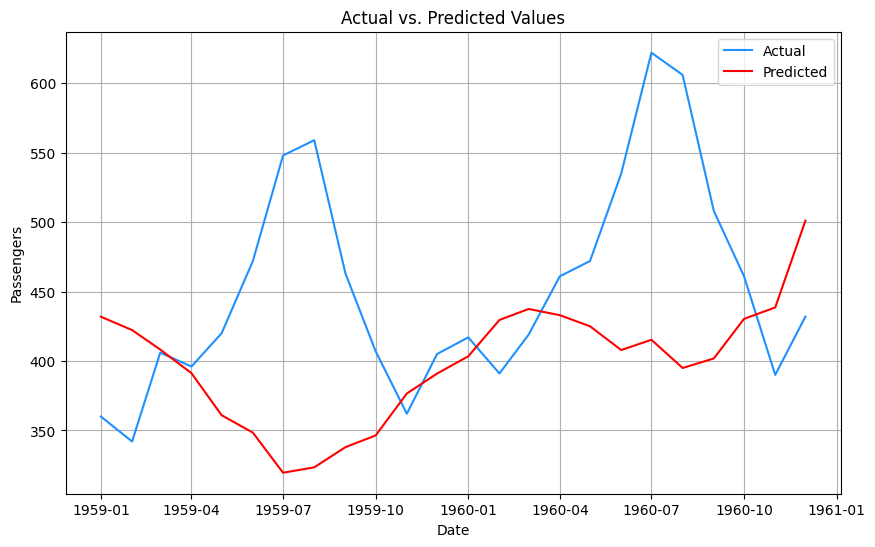

In [14]:
# Plot the test data and predictions
original_test_data = data[-24:]
plot_predictions(original_test_data, final_pred)

In [15]:
# Calculate metrics
mape = mean_absolute_percentage_error(original_test_data, final_pred)
mae = mean_absolute_error(original_test_data, final_pred)
mse = mean_squared_error(original_test_data, final_pred)
rmse = np.sqrt(mse)

# Create dictionary
metrics_dict = {
    'MAPE': mape,
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Value']).T
metrics_df.index.name = 'Metric'
metrics_df = metrics_df.round(3)
display(metrics_df)

,Value
Metric,
MAPE,0.167
MAE,81.883
MSE,11900.152
RMSE,109.088
